# Modelling Itokawa gravity field via ANNs
In this notebook we explore the possibility to use ANNs to represent the shape and density of Itokawa.

The mascon model for Itokawa was generated in a different notebook

To run this notebook (and the others) create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib jupyter pytorch
 conda activate geodesyann
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
```


In [3]:
# core stuff
import h5py
import numpy as np
import scipy
from copy import deepcopy
import os
import pickle as pk

# pytorch
from torch import nn
import torch
# For debugging and development purposes this is now set to float64 ... change for speed on GPUs
torch.set_default_tensor_type(torch.DoubleTensor)

# misc
import sobol_seq
from scipy import integrate
from sklearn.neighbors import NearestNeighbors
import open3d as o3d


# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

ModuleNotFoundError: No module named 'open3d'

# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
with open("mascons/Itokawa_mascon.pk", "rb") as file:
    point_cloud, masses = pk.load(file)

In [3]:
x_raw = point_cloud[:,0]
y_raw = point_cloud[:,1]
z_raw = point_cloud[:,2]
print("N. particles: ", len(x_raw))
print("N. masses: ", len(masses))

N. particles:  5395
N. masses:  5395


In [4]:
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(point_cloud)
distances, indices = nbrs.kneighbors(point_cloud)

print("Minimum distance between particles: ", min(distances[:,1]))
print("Maximum distance between particles: ", max(distances[:,1]))

x = x_raw
y = y_raw
z = z_raw



Minimum distance between particles:  1.3898048808026549
Maximum distance between particles:  25.257483157232752


In [5]:
# We subtract the mean so that the origin is the center of figure
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)
# We normalize so that the masses are at most at 0.9
max_value = max([max(abs(it)) for it in [x,y,z]])
x = x / max_value * 0.9
y = y / max_value * 0.9
z = z / max_value * 0.9
# We normalize the masses so that the mass is 1
masses = torch.tensor(masses / sum(masses))

# These will be used to form the file name to save runs
hollow = ""
key = "Itokawa"
cluster_name = ""

# Uncomment the lines below to create a hollow sphere inside the asteroid. 
#x_pos = 0.3
#hole_r = 0.3
#mask = ((x-x_pos)**2 +y**2+z**2) > 0.3
#y= y[mask]
#z= z[mask]
#x= x[mask]
#hollow = "hollow_" + str(x_pos) + "_"  + str(hole_r)

# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x, np.append(y,z))
point_cloud = point_cloud.reshape((3,len(x)))
point_cloud = np.transpose(point_cloud)
point_cloud = torch.tensor(point_cloud)

### Visualization via matplotlib

<IPython.core.display.Javascript object>


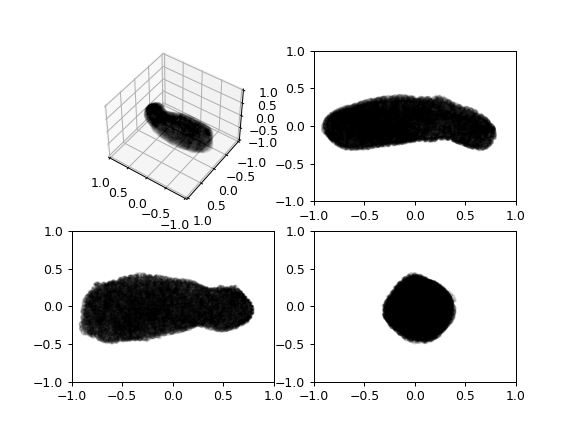

(-1.0, 1.0)

In [6]:
fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')
plot_radius = 10

# And visualize the masses
ax.scatter(x, y, z, color = 'k', s = masses*100000, alpha=0.01)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(elev=45., azim=125.)

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, color = 'k', s = masses*100000, alpha=0.1)
ax2.set_xlim([-1,1])
ax2.set_ylim([-1,1])

ax3 = fig.add_subplot(223)
ax3.scatter(x, z, color = 'k', s = masses*100000, alpha=0.1)
ax3.set_xlim([-1,1])
ax3.set_ylim([-1,1])

ax4 = fig.add_subplot(224)
ax4.scatter(y, z, color = 'k', s = masses*100000, alpha=0.1)
ax4.set_xlim([-1,1])
ax4.set_ylim([-1,1])

### Visualization via open3d

WARNINGS: Makes only sense for convex shapes as it visualizes the convex hull.

In [8]:
# We color the points w.r.t. their distance to the center
color = [np.linalg.norm([point]) for point in point_cloud.numpy()] 
colors = np.exp(-np.array(color))
colors = np.append(np.append(colors, colors), colors).reshape((3, len(color))).transpose()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.colors = o3d.utility.Vector3dVector(colors)


hull, _ = pcd.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcd, hull_ls])

# Computing the gravitational potential of the ground truth the asteroid
The Canvendish constant is not included (or $G=1$), so that we have:
$$
U_L = - \sum_{i=1}^N \frac{m_i}{|\mathbf x - \mathbf r_i|}
$$
where, assuming the asteroid with a unitary mass $m_i = 1/N$, hence:
$$
U_L = - \frac 1N \sum_{i=1}^N \frac{1}{|\mathbf x - \mathbf r_i|}
$$

In [9]:
# This will create the labels for the supervised learning
def U_L(target_points, point_cloud, masses):
    retval=torch.empty(len(target_points),1)
    for i, target_point in enumerate(target_points):
        retval[i] = torch.sum(masses/torch.norm(torch.sub(point_cloud,target_point), dim=1))
    return - retval 

In [10]:
target_points = torch.rand(100,3)

In [11]:
%timeit U_L(target_points, point_cloud, masses)

224 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Representing an asteroid via a neural network


## 1 - Instantiating the network
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [12]:
# All encodings work taking as input a tensor (N, 3) containing the cartesian coordinates of N points
# and returning a tensor of (N, M) that can be used as input to the ANN

# Encoding N.1 (directional encoding):
# x = [x,y,z] is encoded as [ix, iy, iz, r]
class directional_encoding:
    def __init__(self):
        self.n_inputs = 4
        self.name = "directional_encoding"
    # sp: sampled points
    def __call__(self, sp):
        unit = sp / torch.norm(sp,dim=1).view(-1,1)
        return torch.cat((unit, torch.norm(sp,dim=1).view(-1,1)), dim=1)

# Encoding N.2 (positional encoding):
# x = [x,y,z] is encoded as [sin(pi x), sin(pi y), sin(pi z), cos(pi x), cos(pi y), cos(pi z), sin(2 pi x), ....]
class positional_encoding:
    def __init__(self, N):
        self.n_inputs = 6 * N
        self.name = "positional_encoding_" + str(N)
    def __call__(self, sp):
        retval = torch.cat((torch.sin(np.pi * sp).view(-1,3),torch.cos(np.pi * sp).view(-1,3)), dim=1)
        for i in range(1, self.n_inputs // 6):
            retval = torch.cat((retval, torch.sin(2**i*np.pi * sp).view(-1,3),torch.cos(2**i*np.pi * sp).view(-1,3)), dim=1)
        return retval

# Encoding N.3 (direct encoding):
class direct_encoding:
    def __init__(self):
        self.n_inputs = 3
        self.name = "direct_encoding"
    def __call__(self, sp):
        return sp
        
# Encoding N.4 (spherical coordinates). These can be used with positional encoding to create effectively harmonics
class spherical_coordinates:
    def __init__(self):
        self.n_inputs = 3
        self.name = "spherical_coordinates"
    def __call__(self, sp):
        phi = torch.atan2(sp[:,1], sp[:,0]) / np.pi
        r = torch.norm(sp, dim=1)
        theta = torch.div(sp[:,2], r)
        return torch.cat((r.view(-1,1), phi.view(-1,1), theta.view(-1,1)), dim=1)
    

In [13]:
# Encoding choosen
encoding = direct_encoding()

# Network initialization scheme (note that if xavier uniform is used all outputs will start at, roughly 0.5)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.uniform_(m.bias.data, -0.0, 0.0)

# Network architecture. Note that the dimensionality of the first linear layer must match the output
# of the encoding chosen
n_neurons = 100
model = nn.Sequential(
          nn.Linear(encoding.n_inputs,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_  = model.apply(weights_init)

In [14]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
#model.load_state_dict(torch.load("models/" + sample + "_" + cluster_name + "_" + encoding.name + "_" + hollow + ".mdl"))

## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function and as such it is difficult to plot. 

### Approach 1: plotting a grid of points colored with the rho value

<IPython.core.display.Javascript object>


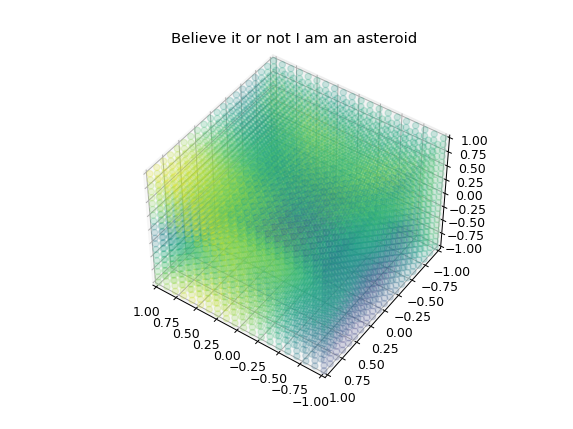

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [15]:
def plot_asteroid1(model, encoding, N=20, bw = False, ax = None, alpha = 0.2, views_2d = False):
    # We create the grid
    x = torch.linspace(-1,1,N)
    y = torch.linspace(-1,1,N)
    z = torch.linspace(-1,1,N)
    X, Y, Z = torch.meshgrid((x,y,z))

    # We compute the density on the grid points (no gradient as its only for plotting)
    nn_inputs = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)), dim=1)
    nn_inputs = encoding(nn_inputs)
    RHO = model(nn_inputs).detach()
 
    # And we plot it
    fig = plt.figure()
    if views_2d:
        ax = fig.add_subplot(221, projection='3d')
    else:
        ax = fig.add_subplot(111, projection='3d')
    if bw:
        col = torch.cat((1-RHO, 1-RHO, 1-RHO, RHO), dim=1)
        alpha = None
    else:
        col = RHO
    
    ax.scatter(X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1), marker='.', c=col, s=100, alpha = alpha)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.view_init(elev=45., azim=125.)
    
    if views_2d:
        ax2 = fig.add_subplot(222)
        ax2.scatter(X.reshape(-1,1)[:,0], Y.reshape(-1,1)[:,0], marker='.', c=col, s=100, alpha=alpha)
        ax2.set_xlim([-1,1])
        ax2.set_ylim([-1,1])

        ax3 = fig.add_subplot(223)
        ax3.scatter(X.reshape(-1,1)[:,0], Z.reshape(-1,1)[:,0], marker='.', c=col, s=100, alpha=alpha)
        ax3.set_xlim([-1,1])
        ax3.set_ylim([-1,1])

        ax4 = fig.add_subplot(224)
        ax4.scatter(Y.reshape(-1,1)[:,0], Z.reshape(-1,1)[:,0], marker='.', c=col, s=100, alpha=alpha)
        ax4.set_xlim([-1,1])
        ax4.set_ylim([-1,1])
    
    return fig
       
fig = plot_asteroid1(model, encoding, bw = False, views_2d=False)
plt.title("Believe it or not I am an asteroid")

### Approach 2: considering rho as a probability density function and sampling points from it

<IPython.core.display.Javascript object>


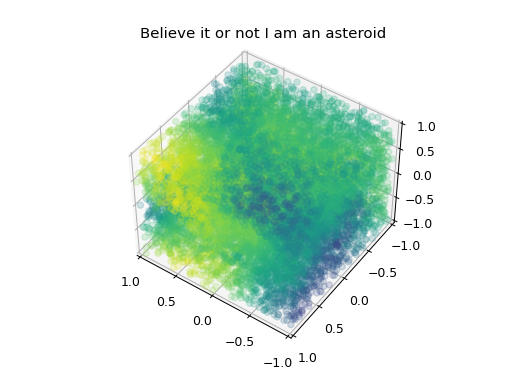

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [16]:
# Rejection sampling
def plot_asteroid2(model, encoding, N=30**3, views_2d = False, bw = False, alpha = 0.2, crop_p = 1e-2, s= 100):
    points = torch.rand(N, 3) *2 -1
    nn_inputs = encoding(points)
    RHO = model(nn_inputs).detach()
    mask = RHO > (torch.rand(N,1) + crop_p)
    RHO = RHO[mask]
    points = [[it[0].item(), it[1].item(), it[2].item()] for it,m in zip(points, mask) if m] 
    points = torch.tensor(points)
    fig = plt.figure()
    if views_2d:
        ax = fig.add_subplot(221, projection='3d')
    else:
        ax = fig.add_subplot(111, projection='3d')
    if bw:
        col = 'k'
    else:
        col = RHO
    # And we plot it
    ax.scatter(points[:,0], points[:,1], points[:,2], marker='.', c=col, s=s, alpha=alpha)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.view_init(elev=45., azim=125.)

    
    if views_2d:
        ax2 = fig.add_subplot(222)
        ax2.scatter(points[:,0], points[:,1], marker='.', c=col, s=s, alpha=alpha)
        ax2.set_xlim([-1,1])
        ax2.set_ylim([-1,1])

        ax3 = fig.add_subplot(223)
        ax3.scatter(points[:,0], points[:,2], marker='.', c=col, s=s, alpha=alpha)
        ax3.set_xlim([-1,1])
        ax3.set_ylim([-1,1])

        ax4 = fig.add_subplot(224)
        ax4.scatter(points[:,1], points[:,2], marker='.', c=col, s=s, alpha=alpha)
        ax4.set_xlim([-1,1])
        ax4.set_ylim([-1,1])
    
    return fig
    
plot_asteroid2(model, encoding)
plt.title("Believe it or not I am an asteroid")

# Note that if the network is initialized by xavier the density will roughly be 0.5 everywhere so rejection sampling
# will also create a uniform cloud of points

## Computing the gravitational potential of the asteroid ANN model wia Monte Carlo methods
The Network represents the mass density $\rho$, but the potential field created by it is given by the integral:
$$
U_P = - \int_V \frac\rho {|\mathbf r-\mathbf x|}  dV 
$$
where the volume V is the cube $[-1,1]^3$. 

We thus must approximate the above integral, and to do so we use the Monte Carlo formula:
$$
\int_V f(\mathbf x) dv = \frac 1N \sum_i \frac{f(\mathbf x_i)}{g(\mathbf x_i)}
$$
where g is the pdf of the distribution we sample $x_i$ from.

Applying the formula above to our integral we get:

- Naive Monte Carlo
$$
U_P(\mathbf r) \approx \frac 8N \sum_i \frac {\rho_i}{|\mathbf r-\mathbf x_i|} 
$$


where we assumed that $g$ was the uniform random distribution.

Improvements to the above strategy are often a) the use of low-discrepancy seqeunces, b) importance sampling and c) MCMC methods. While a) is indeed applicable, b) and c) seem problematic in our case.

In [17]:
# We generate a low-discrepancy sequence here and keep it in memory (generating it requires some CPU time)
sobol_points = sobol_seq.i4_sobol_generate(3, 200000)

# Naive Montecarlo
def U_Pmc(target_points, model, N = 3000):
    # We generate randomly points in the [-1,1]^3 bounds
    sample_points = torch.rand(N,3) * 2 - 1
    nn_inputs = encoding(sample_points)
    rho = model(nn_inputs)
    retval=torch.empty(len(target_points),1)
    # Only for the points inside we accumulate the integrand (MC method)
    for i, target_point in enumerate(target_points):
        retval[i] = torch.sum(rho/torch.norm(target_point - sample_points, dim=1).view(-1,1)) / N
    return  - 8 * retval

# Low-discrepancy Montecarlo
def U_Pld(target_points, model, N = 3000, noise = 1e-5):
    # We generate randomly points in the [-1,1]^3 bounds
    sample_points = torch.tensor(sobol_points[:N,:] * 2 - 1) + torch.rand(N,3) * noise
    nn_inputs = encoding(sample_points)
    rho = model(nn_inputs)
    retval=torch.empty(len(target_points),1)
    # Only for the points inside we accumulate the integrand (MC method)
    for i, target_point in enumerate(target_points):
        retval[i] = torch.sum(rho/torch.norm(target_point - sample_points, dim=1).view(-1,1)) / N
    return  - 8 * retval

# Importance sampling could be a third approach to use here and benchmark .. so far we did not have success
# in assembling an algorithm able to

In [18]:
# Here we create some target points where to time the potential computation
N_try = 1
target_points = (torch.rand(N_try,3)*2-1)*1.1
a = torch.logical_and((target_points[:,0]>-1),(target_points[:,0]<1))
b = torch.logical_and((target_points[:,1]>-1),(target_points[:,1]<1))
c = torch.logical_and((target_points[:,2]>-1),(target_points[:,2]<1))
d = torch.logical_and(torch.logical_or(a,b), c)
target_points=target_points[d]
print("Target point is: ", target_points)

Target point is:  tensor([], size=(0, 3))


#### We time the MC methods

In [19]:
%timeit U_Pld(target_points, model, N = 10000)

47.6 ms ± 8.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit U_Pmc(target_points, model, N = 10000)

45.7 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [21]:
# Here we set some details of the training
# This loss function adds a normalization constant to the network outputs so
# that the MSE is minimized. Like this it is only the mass distribution to count
# not its absolute value. Seems on paper a great idea, everybody should do it .. but does it work?
def normalized_loss(predicted, labels):
    c = sum(torch.mul(labels, predicted))/sum(torch.pow(predicted,2))
    return sum(torch.pow(torch.sub(labels,c*predicted),2)) / len(labels)

# Here we set the loss function
#loss_fn = torch.nn.MSELoss()
loss_fn = normalized_loss

# Here we set the choosen Monte Carlo method
mc_method = U_Pld

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# This is the main training loop
for i in range(10000):
    # At each new epoch we generate new points (its like a new batch), but we make sure
    # they are outside the unit cube
    targets = (torch.rand(100,3)*2-1)*1.1
    a = torch.logical_and((targets[:,0]>-1),(targets[:,0]<1))
    b = torch.logical_and((targets[:,1]>-1),(targets[:,1]<1))
    c = torch.logical_and((targets[:,2]>-1),(targets[:,2]<1))
    d = torch.logical_and(torch.logical_or(a,b), c)
    targets=targets[d]
    labels = U_L(targets, point_cloud, masses)
    
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(targets, model, N=100000)
    loss = loss_fn(predicted, labels)
    print(i, loss.item())
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 0.00015563045837901606
1 6.63788963672542e-05
2 9.131500449616852e-05
3 6.981302303642223e-05
4 5.1029896472938786e-05
5 0.00014572444591976147
6 9.623598502540163e-05
7 0.00015342236957783116
8 0.00016331743758211768
9 9.099756081077134e-05
10 0.00020195112476243792
11 6.637374244565733e-05
12 8.959716366973517e-05
13 0.00012875718477340083
14 3.785221753146886e-05
15 0.00010247865421937891
16 0.00011850199884160164
17 0.0005641415095498691
18 7.015519037759269e-05
19 0.0001299933564360724
20 4.067839530018822e-05
21 8.085884169537594e-05
22 0.00011061446888245205
23 0.00010709984371058572
24 0.0001715151194864315
25 8.327040854804989e-05
26 3.22496419661071e-05
27 2.5307526442428126e-05
28 9.866837860071138e-05
29 0.00014556975269440568
30 9.281988268184727e-05
31 5.155814113359302e-05
32 0.00017103822620451355
33 2.443664190855072e-05
34 0.0002276735978553528
35 9.592338476882221e-05
36 4.3259398422955876e-05
37 0.0001465871057841567
38 6.0057706699800693e-05
39 8.861291849237528e

316 0.00010129473402435273
317 5.595493603844438e-05
318 0.00012566987518664022
319 3.94890958054363e-05
320 2.1705530870600876e-05
321 5.214532682824287e-05
322 3.8903574295794876e-05
323 3.0348677610825223e-05
324 4.447252955327682e-05
325 7.177390068077797e-05
326 3.140443961225174e-05
327 1.8368263078849566e-05
328 2.2008192929298327e-05
329 6.453434413402663e-05
330 7.356653591484742e-05
331 5.0144018783116826e-05
332 5.6152822659475874e-05
333 1.139910190761745e-05
334 9.015223338898885e-05
335 6.340441600122275e-05
336 0.00010071973743051312
337 4.962820650132931e-05
338 0.00011792966325863492
339 4.057422516097725e-05
340 5.729244480739527e-05
341 6.321551063120739e-05
342 2.2796699151597748e-05
343 0.00012016808639032909
344 2.604754846948876e-05
345 6.592320687650835e-05
346 3.7335830843475515e-05
347 3.0010601884201403e-05
348 5.822400542678448e-05
349 5.8663382403435934e-05
350 4.370950826232459e-05
351 3.323268351929347e-05
352 9.787807216345258e-06
353 0.00017991796172624

628 1.723887836722469e-05
629 2.4928033318658107e-05
630 7.189585609764631e-05
631 3.709497411343904e-05
632 4.877851787064401e-05
633 9.431107389838802e-06
634 1.760364313020918e-05
635 3.632496364569468e-05
636 6.678423360914344e-05
637 0.00012000229598866261
638 1.6987421151169174e-05
639 9.077905050552929e-05
640 4.1814373543033294e-05
641 3.0029418825498883e-05
642 4.821617088841695e-05
643 7.963147776520718e-05
644 0.00011208391809070753
645 2.7735657216612944e-05
646 3.525648510596031e-05
647 4.16406391710899e-05
648 0.00010082864994860462
649 1.867593237215764e-05
650 7.904309057458238e-05
651 3.233648169848964e-05
652 5.4859479266651265e-05
653 5.702451508327435e-05
654 5.76451105201703e-05
655 8.598397308274535e-06
656 8.87580878444802e-06
657 4.5079247548548534e-05
658 8.76835553242083e-05
659 0.00039924525120594537
660 9.704694455351573e-05
661 2.6274675469182767e-05
662 3.589924979564999e-05
663 6.883355046676841e-05
664 2.3589075224047823e-05
665 6.864566968698277e-05
666

940 3.11385797490259e-05
941 1.1840409615140943e-05
942 5.415899598778824e-05
943 2.7384419247392232e-05
944 4.0180930182964e-05
945 5.071416458322033e-05
946 3.4438428970314814e-05
947 5.2372293793309457e-05
948 5.933772775332555e-05
949 3.952359052151918e-05
950 0.003320649879420807
951 5.200700146689416e-05
952 9.928572276215546e-05
953 0.0004239390819005025
954 0.0002433728486132304
955 6.828822051451703e-05
956 0.00010734201587991119
957 0.0001023203358436201
958 0.00010157800103691355
959 0.00014624792811537195
960 6.167922651460486e-05
961 4.635659389133382e-05
962 7.452262306713787e-05
963 0.00010811443635562262
964 0.00013040408268921274
965 9.502558128796937e-05
966 5.6794238901495265e-05
967 4.719740364655034e-05
968 3.262015947580689e-05
969 6.99005117410914e-05
970 5.978592397158733e-05
971 8.768634974000546e-05
972 5.272034737826819e-05
973 4.9023693810608576e-05
974 3.323718759025169e-05
975 7.89002665126066e-05
976 0.00013828133477284112
977 2.0955316433730505e-05
978 3

1243 3.254219141176446e-05
1244 7.766104941809039e-05
1245 2.790498919156678e-05
1246 9.019447139738959e-05
1247 3.695754036922963e-05
1248 3.9923661126326736e-05
1249 3.3780033673416837e-05
1250 1.5850688117061347e-05
1251 1.8700793065854067e-05
1252 2.5317522677305935e-05
1253 2.8774376736311265e-05
1254 3.1461275837774716e-05
1255 3.254388413819593e-05
1256 6.250251160135432e-05
1257 4.8603697111329845e-05
1258 2.328575460059576e-05
1259 6.494112104411955e-05
1260 3.1045299370053024e-05
1261 2.9628122222193068e-05
1262 5.126100120145048e-05
1263 6.33025660819687e-05
1264 4.59405179303177e-05
1265 1.9556232276078387e-05
1266 2.1573161917775027e-05
1267 2.3686985805791185e-05
1268 5.8313568170601607e-05
1269 1.1647987120260956e-05
1270 1.2658753739074222e-05
1271 3.879300427118485e-05
1272 7.712412790393983e-05
1273 3.989069319630336e-05
1274 3.382500418963326e-05
1275 1.7961693257590212e-05
1276 2.2535603184485497e-05
1277 3.3024743694401906e-05
1278 1.5332895485814774e-05
1279 5.940

1542 4.685375216611747e-06
1543 2.1266862030898973e-05
1544 4.9299511339239055e-05
1545 3.6352630521828366e-05
1546 2.4517245214106113e-05
1547 3.329356854847427e-05
1548 2.5182404028567842e-05
1549 2.79528983430227e-05
1550 2.4600673777214535e-05
1551 2.7284505434323194e-05
1552 3.792823766760487e-05
1553 4.52042883288345e-05
1554 3.613433759499957e-05
1555 2.280086863359709e-05
1556 3.179446565505539e-05
1557 2.7711282200792207e-05
1558 9.500242205380905e-06
1559 2.982090174800114e-05
1560 3.7349733482858256e-05
1561 2.7835118427864893e-05
1562 1.3695386981848508e-05
1563 1.7237801486792978e-05
1564 3.5582134031909024e-05
1565 2.4893552499586433e-05
1566 1.9042263182431355e-05
1567 0.00010392139650999695
1568 2.1148009988437047e-05
1569 1.7006481796343923e-05
1570 2.302937744927848e-05
1571 3.156584297291191e-05
1572 5.367659123841626e-05
1573 4.116126261705181e-05
1574 1.2144791149014906e-05
1575 1.120075742650205e-05
1576 1.8265759009143197e-05
1577 3.0502340440470923e-05
1578 2.29

1842 4.0413980030315114e-05
1843 7.699183790367823e-05
1844 8.74094563212118e-05
1845 2.022943750077775e-05
1846 0.0001273705028836753
1847 2.2501761047202844e-05
1848 5.7870553997849047e-05
1849 3.64908470483712e-05
1850 9.159247175018842e-05
1851 7.172178289299784e-05
1852 4.8625478726579655e-05
1853 1.7639936176884043e-05
1854 3.671726869308527e-05
1855 5.0808486205651646e-05
1856 6.66181506074542e-05
1857 9.047239047722414e-06
1858 3.056095513317494e-05
1859 2.14543147542952e-05
1860 1.992206114384439e-05
1861 2.3173883363258182e-05
1862 3.805860351370646e-05
1863 4.30222703817351e-05
1864 1.1836425412758599e-05
1865 8.708764004742777e-06
1866 2.5513904200617054e-05
1867 3.43928412832065e-05
1868 1.043473246508758e-05
1869 3.19502514012717e-05
1870 0.00043859681398764045
1871 5.41303172635392e-05
1872 1.3739179859185432e-05
1873 3.2894966487399464e-05
1874 7.10636456432752e-05
1875 9.531650299902128e-05
1876 1.8633401265841232e-05
1877 5.974316513735251e-05
1878 2.7684437133642846e

2142 5.7723048980514776e-05
2143 1.0216182900740751e-05
2144 4.849972124536604e-05
2145 2.6887048014044108e-05
2146 0.0001415239197846277
2147 4.676318430389852e-05
2148 1.3915199319157853e-05
2149 2.2586708600713503e-05
2150 6.486549768458444e-05
2151 5.7327981383372776e-05
2152 2.2919378757108466e-05
2153 3.894436730626199e-05
2154 6.920654731260519e-05
2155 1.8056420627043092e-05
2156 5.165330238501179e-05
2157 3.0871415101880315e-05
2158 2.0952896231190334e-05
2159 2.3762226378503868e-05
2160 0.00014111109262271687
2161 3.775252064275174e-05
2162 8.387334078824534e-05
2163 1.736307753642866e-05
2164 4.2313635202639355e-05
2165 3.8643898267801215e-05
2166 3.256846132181377e-05
2167 2.8632338348791973e-05
2168 3.6073640212936855e-05
2169 7.574288725658165e-05
2170 1.7364928994704726e-05
2171 3.512251028768682e-05
2172 2.590176881698436e-05
2173 1.9564734664140918e-05
2174 1.9729418789628024e-05
2175 3.6077951459260094e-05
2176 2.9844119982171104e-05
2177 6.750475177146108e-05
2178 6.

2441 4.648852416649762e-05
2442 1.3381364533720178e-05
2443 0.000654078380346911
2444 3.715718252898934e-05
2445 3.873438348508025e-05
2446 1.704063634081833e-05
2447 5.030289064077393e-05
2448 1.4621274273362529e-05
2449 1.996891680065381e-05
2450 1.0110767028491652e-05
2451 2.5561645807204864e-05
2452 1.8697023946778002e-05
2453 3.563383150217125e-05
2454 2.3122844444451684e-05
2455 2.138742346330817e-05
2456 2.4360080134488387e-05
2457 1.792712231388422e-05
2458 2.3615301997734427e-05
2459 7.05968802106718e-06
2460 2.279067823335466e-05
2461 1.885853359446308e-05
2462 5.5675147186139034e-05
2463 3.032039524453916e-05
2464 1.0491851809809752e-05
2465 1.3845992033918187e-05
2466 4.3165480371667666e-05
2467 9.079678248768007e-05
2468 6.176599181055849e-06
2469 1.4241338309387779e-05
2470 6.90941899924326e-05
2471 2.9410296875019493e-05
2472 2.2699462417971435e-05
2473 1.3914617414291518e-05
2474 4.56131841251043e-05
2475 3.473689642477918e-05
2476 3.841180088460485e-05
2477 1.472209222

2740 1.6096946730443633e-05
2741 2.428481775096496e-05
2742 1.8107217666772906e-05
2743 1.1711833917741867e-05
2744 2.1461142889533e-05
2745 1.622056495128697e-05
2746 0.00011594617362652053
2747 1.936967726723501e-05
2748 4.664007996681442e-05
2749 3.698606274418086e-05
2750 1.880801649042209e-05
2751 3.822885396982204e-05
2752 7.54516847040383e-06
2753 0.00017272114889980145
2754 5.48101170328025e-05
2755 3.6311588928633926e-05
2756 2.94382060051407e-05
2757 2.5494982094058614e-05
2758 1.442680073015338e-05
2759 3.255163087304945e-05
2760 4.584636181832751e-05
2761 3.415199016650762e-05
2762 2.5404308314043054e-05
2763 3.5386062563761554e-05
2764 4.7850077122713656e-05
2765 1.8606836493627266e-05
2766 4.841341692192239e-05
2767 1.7310127975486943e-05
2768 1.0601012890615432e-05
2769 4.67837396126687e-05
2770 6.939156575774871e-05
2771 1.868318789978613e-05
2772 3.568618599566789e-05
2773 5.336269374500145e-05
2774 4.41512365972284e-05
2775 8.760422675132796e-06
2776 1.197961095933481

3040 2.180347069759437e-05
3041 1.1190233487167048e-05
3042 2.42983186092017e-05
3043 1.4640649684327299e-05
3044 1.616836237169958e-05
3045 1.7861017701329647e-05
3046 3.935072099532834e-05
3047 5.2000064527143194e-05
3048 8.603876065920197e-06
3049 2.500466069751794e-05
3050 5.333866936775006e-05
3051 4.435157676088955e-05
3052 3.099516691711626e-05
3053 3.9424859729923944e-05
3054 1.8108852106255998e-05
3055 3.959365571862948e-06
3056 3.131204336605591e-05
3057 4.0997919276058955e-05
3058 1.650174694060831e-05
3059 2.697997138318316e-05
3060 5.27312600863257e-06
3061 6.300880418314527e-06
3062 3.083969529992367e-05
3063 4.00278682356689e-05
3064 4.1235857269570016e-05
3065 3.209019995544661e-05
3066 2.3828203026771484e-05
3067 1.7014519310925784e-05
3068 3.7997806225563716e-05
3069 1.2622338923625807e-05
3070 9.156262203948578e-06
3071 6.190413740210118e-06
3072 7.483587242027966e-06
3073 1.6573753129061518e-05
3074 1.264708132221858e-05
3075 1.626492164219868e-05
3076 7.99071227869

3339 2.3213261306517283e-05
3340 9.712938864141533e-06
3341 6.418757600950886e-05
3342 2.918895561236767e-05
3343 1.412932376981688e-05
3344 2.6068044354407396e-05
3345 3.0499180264799514e-05
3346 2.54288934646139e-05
3347 0.0001329838282131818
3348 4.9096686519740394e-05
3349 7.255600858440488e-05
3350 2.809151424500181e-05
3351 3.1788590415007176e-05
3352 3.572896203219789e-05
3353 3.957203441672053e-05
3354 4.690069352374165e-05
3355 9.031697700764796e-06
3356 1.4404522378436375e-05
3357 2.771055422957348e-05
3358 0.00021044199169129388
3359 9.033770643813347e-06
3360 5.53008949804572e-05
3361 3.962433666325868e-05
3362 7.112790914895078e-05
3363 1.0633275779450576e-05
3364 1.0289179733693815e-05
3365 5.838766647944123e-05
3366 6.460877197385306e-05
3367 6.957886181504486e-05
3368 2.8065741973125687e-05
3369 5.057317861588442e-05
3370 1.80376928168189e-05
3371 2.8215560539377616e-05
3372 2.4640074968847974e-05
3373 4.9935048858925846e-05
3374 3.736148289618103e-05
3375 1.91162141701

3638 1.1542900935812206e-05
3639 8.163520726020464e-06
3640 1.3287456508016337e-05
3641 1.7724581017261767e-05
3642 3.7500064727069424e-05
3643 4.5958597126181865e-06
3644 1.0252461330526751e-05
3645 3.572406404681446e-05
3646 3.423948947775912e-05
3647 5.433106668306122e-05
3648 7.951141492989436e-06
3649 1.1040277583511618e-05
3650 4.6030825119255295e-05
3651 5.2044432851246896e-05
3652 5.016636446627124e-06
3653 2.395866431725573e-06
3654 3.6579700359593084e-05
3655 1.3648342775666067e-05
3656 1.9965341906744e-05
3657 1.4046723859000249e-05
3658 4.116366731121312e-06
3659 2.247440273389126e-05
3660 2.8896956037949805e-06
3661 5.408642432761768e-05
3662 6.409928484124256e-06
3663 2.381139927072425e-05
3664 2.563690566308654e-05
3665 1.8303342547006365e-05
3666 1.0482968871562198e-05
3667 5.299003216286937e-05
3668 1.6220573304343317e-05
3669 6.669160530821206e-05
3670 2.024741273347212e-05
3671 1.0857310760250941e-05
3672 3.0316589460741725e-05
3673 3.043105655307631e-05
3674 2.71576

3937 2.144130441836989e-05
3938 4.205679702150668e-06
3939 7.92256395033005e-06
3940 4.795559876918173e-05
3941 2.5774705584375626e-05
3942 4.85476591362155e-06
3943 3.92778902607573e-05
3944 2.453589298049568e-05
3945 7.004533936557546e-05
3946 3.6443205587769956e-05
3947 1.6384997260505977e-05
3948 3.8865103930322e-05
3949 9.934717820828653e-06
3950 1.6988497737475165e-05
3951 2.447775353715515e-05
3952 3.264107993971081e-06
3953 2.1349952070325696e-05
3954 1.1499749197333249e-05
3955 4.2068249911871834e-05
3956 0.00023627923951410993
3957 1.65112715270758e-06
3958 8.498253494095739e-06
3959 4.259226334945875e-05
3960 3.959951990105739e-05
3961 1.3213535039885427e-05
3962 3.4832643933981205e-05
3963 4.502835503227899e-05
3964 5.619468945504817e-05
3965 1.4914328863206263e-05
3966 2.664679332893943e-05
3967 3.1885868344804e-05
3968 1.559741995041924e-05
3969 1.006496024108549e-05
3970 1.9361714758072776e-05
3971 4.396652941496882e-05
3972 3.253596852740059e-05
3973 1.2885219845615848e

4237 3.110264133325732e-05
4238 0.00013925063265187286
4239 1.8920543067916122e-05
4240 0.0001028868510071542
4241 1.682626225842422e-05
4242 2.8998239679238674e-05
4243 6.681348070645876e-06
4244 2.6284681126944673e-05
4245 6.929315124801586e-05
4246 3.2621866254113496e-05
4247 2.7464092168895522e-05
4248 2.6466017592221042e-05
4249 6.841474316097445e-06
4250 1.0264931164556095e-05
4251 1.5369013562699678e-05
4252 9.142600028234035e-06
4253 1.3279104506103278e-05
4254 2.990856769502737e-05
4255 2.1227772616177218e-05
4256 9.696539885701937e-05
4257 2.3240524633692068e-05
4258 5.6296641688053636e-05
4259 5.199075538064114e-05
4260 1.4234197971318236e-05
4261 8.478356412295431e-06
4262 2.5387459490431983e-05
4263 0.00012138031228200925
4264 1.3712306023443533e-05
4265 6.232633008613047e-05
4266 3.189761146427345e-05
4267 1.0458897711563372e-05
4268 7.336016221545266e-05
4269 4.8179589831972876e-05
4270 4.1578966270888146e-05
4271 3.782505962193932e-05
4272 4.05721684274434e-05
4273 1.21

4535 2.730243657767455e-05
4536 7.064027708469543e-06
4537 3.69848638868012e-05
4538 1.5279596995280597e-05
4539 1.7853823557168323e-05
4540 1.5272100559215233e-05
4541 8.170480498190967e-06
4542 5.066525707685227e-06
4543 7.157311470149061e-06
4544 3.0037495823814224e-05
4545 0.00013605516982960938
4546 1.1515061391367386e-05
4547 2.6091586935241956e-06
4548 3.2826840051060906e-05
4549 5.239492657873733e-06
4550 3.6246720040941034e-05
4551 3.9162569027842466e-05
4552 9.942460239517789e-06
4553 1.4923593579179125e-05
4554 9.76422813020411e-05
4555 8.597603401538381e-06
4556 1.6648991529298097e-05
4557 1.3544557734603277e-05
4558 1.0674425686635426e-05
4559 5.162937342923223e-06
4560 1.938584745818498e-05
4561 2.9781864823846e-05
4562 3.444357379752781e-05
4563 1.9646923607510335e-05
4564 9.451601948902944e-05
4565 3.060031607134324e-06
4566 3.9046885995566666e-05
4567 1.586027201970781e-05
4568 2.185298034516351e-05
4569 8.759781364147187e-06
4570 2.6408541379596845e-05
4571 1.16599206

4834 7.28797495706815e-05
4835 3.833838048070309e-05
4836 0.00017137835476354124
4837 4.410124691154186e-05
4838 2.8748820224360725e-05
4839 6.363296131937978e-05
4840 4.2823949139747333e-05
4841 0.0002419402243139093
4842 0.0001036140709378581
4843 4.788794397039432e-05
4844 2.915686758297741e-05
4845 5.019152661040784e-05
4846 3.40972360513598e-05
4847 7.454727551245421e-06
4848 3.190259056420453e-05
4849 7.850973178963115e-05
4850 1.4734577493104907e-05
4851 1.405326020590071e-05
4852 1.2126207599002127e-05
4853 2.431430388071385e-05
4854 1.574001964898572e-05
4855 2.580896142746199e-05
4856 1.756449658834217e-05
4857 2.3087120099491774e-05
4858 0.00027521885592394997
4859 4.0537283244276674e-05
4860 2.3158411409011785e-05
4861 3.1522241313019094e-05
4862 3.0447884775564254e-05
4863 3.9743333108950995e-05
4864 3.074677334244851e-05
4865 2.6686650653345833e-05
4866 1.4604122283439733e-05
4867 9.993166572342871e-05
4868 7.45801973521207e-06
4869 1.7667668590370535e-05
4870 4.338472927

5133 0.00010815261666369532
5134 2.7787715968065434e-05
5135 9.247390960417942e-05
5136 4.772567742112679e-05
5137 2.897255655486751e-05
5138 2.4155431395057123e-05
5139 5.738008412346299e-06
5140 6.035524527929824e-05
5141 6.899694286214173e-05
5142 2.174032568211089e-05
5143 1.7750742926737464e-05
5144 1.3835889804467027e-05
5145 2.153744173385059e-05
5146 1.103807822708939e-05
5147 1.4085447753426687e-05
5148 1.9656410330752747e-05
5149 1.1218550102256499e-05
5150 1.7702352213442783e-05
5151 2.8772753453482912e-05
5152 4.8488235171233934e-05
5153 7.659213339568868e-06
5154 6.0653987712585656e-06
5155 7.76835561406287e-05
5156 2.983166402325306e-05
5157 3.0422212961244743e-05
5158 1.8078777786837522e-05
5159 2.749007010373431e-05
5160 1.2458245684280271e-05
5161 1.3481472472629495e-05
5162 1.0934340227214344e-05
5163 5.560191037612908e-05
5164 6.985608227988197e-05
5165 2.7715470108746646e-06
5166 1.0770106457502224e-05
5167 5.2184854159772975e-05
5168 3.273362992503081e-05
5169 1.67

5432 1.1524487773288186e-05
5433 4.902200173999041e-05
5434 4.164180864038546e-05
5435 2.7256237294297877e-05
5436 1.7161696674693805e-05
5437 2.664842098018236e-05
5438 1.9984381099371794e-05
5439 8.044224458665789e-06
5440 2.7600110221318234e-05
5441 1.8095167984115464e-05
5442 3.61734296056828e-05
5443 2.298782291592264e-05
5444 4.6833215231931285e-06
5445 2.220034298623861e-05
5446 2.8137799237099498e-05
5447 4.317352085859959e-05
5448 3.34512549625477e-06
5449 3.817947183956921e-06
5450 1.0989135356575726e-05
5451 1.1037423684480501e-05
5452 2.5010106823911122e-05
5453 1.315907319478801e-05
5454 2.222755256232748e-05
5455 1.5859380512471306e-05
5456 9.88340347657928e-06
5457 1.9911868636902932e-05
5458 1.0917269679246086e-05
5459 3.494631464811516e-05
5460 6.55993191584683e-05
5461 0.00019698793023132367
5462 2.454296904395321e-05
5463 2.2795541723041e-05
5464 4.125499487088976e-05
5465 1.795499238439926e-05
5466 2.4189142100574588e-05
5467 6.5753625904292685e-06
5468 2.1801890787

5731 0.00012098258440923115
5732 0.0004924811034532756
5733 0.000671186124138966
5734 0.0003208376870684073
5735 0.00015120715196092588
5736 6.72355468826723e-05
5737 0.00027612756768436147
5738 0.0003959811209968631
5739 0.0003876847575419999
5740 8.183651024180995e-05
5741 9.677374054761813e-05
5742 8.540000470178389e-05
5743 0.0001206156493023646
5744 0.00026110445912497704
5745 0.00021282300167786282
5746 0.00014081545993579098
5747 7.710469972227114e-05
5748 5.191917130485747e-05
5749 2.258186043836117e-05
5750 6.674203316323295e-05
5751 4.405528006398142e-05
5752 0.00018164568897312963
5753 3.398664579562442e-05
5754 0.0001877830646684479
5755 3.901717935188385e-05
5756 6.749439343914325e-05
5757 5.006522679300905e-05
5758 7.501240973110747e-05
5759 4.05381827832113e-05
5760 4.825178573560955e-05
5761 7.235924305291799e-05
5762 2.00667612034152e-05
5763 4.928592479980095e-05
5764 2.8274464389134105e-05
5765 3.0160981227489986e-05
5766 7.793401997449245e-05
5767 5.2424037892997616

6030 2.090495497729282e-05
6031 4.960537120611048e-05
6032 9.74436041311735e-06
6033 2.996165048471875e-05
6034 1.328767313118598e-05
6035 3.425412117222036e-05
6036 1.8050950909849863e-05
6037 1.3083564741209453e-05
6038 1.2170538645291521e-05
6039 3.6615531523008225e-05
6040 3.513563365341736e-05
6041 5.08021121143837e-06
6042 1.426018462316427e-05
6043 7.062890324446142e-05
6044 5.9120615533369144e-06
6045 0.0005200473799079126
6046 3.340039664064904e-05
6047 6.002929028029152e-05
6048 7.191060731038455e-05
6049 0.00014571853367013296
6050 6.967340197253991e-06
6051 2.6391822502491885e-05
6052 1.859255036594734e-05
6053 6.918699180649096e-05
6054 1.2715073899657548e-05
6055 6.127530227660143e-05
6056 1.9274743260367927e-05
6057 2.5203967570285265e-05
6058 2.7020178486754394e-05
6059 2.858097380574727e-05
6060 5.361482143677812e-05
6061 8.60022892236629e-06
6062 1.3768149098494504e-05
6063 4.452573439488249e-05
6064 2.5784450667412164e-05
6065 8.658930435980731e-06
6066 5.65017904072

6329 2.842142552674314e-05
6330 6.713028158371438e-06
6331 7.788630329892979e-06
6332 3.4902348796279984e-05
6333 6.244147768385509e-06
6334 3.427087833646171e-05
6335 1.9053608633703785e-05
6336 3.911715775490469e-05
6337 2.4700183415373703e-05
6338 2.6422916354417885e-05
6339 6.210556013194396e-05
6340 4.9619232010907164e-05
6341 2.568599573941606e-05
6342 7.100009146833481e-05
6343 3.6456304738617314e-05
6344 1.4878942320725276e-05
6345 5.584211643158049e-06
6346 3.3224498901173086e-05
6347 1.9099094260286725e-05
6348 3.38324142573252e-05
6349 9.863317518761535e-06
6350 4.0887663549175885e-06
6351 1.599918705146638e-05
6352 1.7413718458852423e-05
6353 1.4854332982379097e-05
6354 1.1037508373815847e-05
6355 1.1637592059549916e-05
6356 2.2265093798281833e-05
6357 1.541878790408661e-05
6358 3.411719987757781e-05
6359 9.98016546966052e-06
6360 3.223563137550372e-05
6361 5.6662176890572794e-05
6362 2.9984257810848878e-05
6363 7.709993520776993e-06
6364 1.3734108503313098e-05
6365 8.51808

6628 2.0796272817296784e-05
6629 0.0002714472563875398
6630 2.1275696590739923e-05
6631 5.3441934484211616e-05
6632 5.615131163038151e-05
6633 7.059712616479278e-05
6634 2.6155625170556124e-05
6635 3.549557013721993e-05
6636 2.2923778636209322e-05
6637 2.6945527588879326e-05
6638 1.2878547822942528e-05
6639 9.17686382574143e-06
6640 5.554275080174564e-05
6641 1.1778608824034525e-05
6642 8.122379382332316e-05
6643 2.2377234323215094e-05
6644 3.597723328978358e-05
6645 2.1866799372741462e-05
6646 1.1710884651723651e-05
6647 1.6877149669347687e-05
6648 7.768481920761299e-06
6649 3.4946490031464524e-05
6650 2.1035490832390016e-05
6651 6.7269860558749605e-06
6652 1.163600282292026e-05
6653 4.5211164065672084e-05
6654 1.0156718330111038e-05
6655 1.7791987487519028e-05
6656 2.2211072609886275e-05
6657 6.636254872179824e-06
6658 2.6834617208558948e-05
6659 1.2339081486342312e-05
6660 9.194184231166723e-06
6661 2.612192271998454e-06
6662 2.667685763253163e-05
6663 1.2441647273171563e-05
6664 7.

6928 2.6576920592565152e-05
6929 3.864852285311842e-05
6930 6.607238389625804e-06
6931 3.884188961674991e-05
6932 3.0049442105243768e-05
6933 1.5851941962211487e-05
6934 2.5464781102314416e-05
6935 1.2830603445731048e-05
6936 8.808075669461053e-05
6937 7.812433805800488e-06
6938 1.154172556796856e-05
6939 1.659937083502426e-05
6940 3.229535460828109e-05
6941 1.0675085928572402e-05
6942 4.233657483600363e-05
6943 3.9621891252601545e-05
6944 1.744158182876058e-05
6945 5.40035593975654e-05
6946 6.1009813586538544e-05
6947 1.658086750402448e-05
6948 8.546567951172816e-06
6949 2.1555993876033694e-05
6950 4.235792469764357e-05
6951 2.4680852279640414e-05
6952 1.661595604974111e-05
6953 2.6458727160405084e-05
6954 2.2641942772041924e-05
6955 5.365960015685401e-06
6956 6.40014619392668e-05
6957 4.7991162915363236e-05
6958 1.3059959195381558e-05
6959 1.925527616301316e-05
6960 1.2844688178288585e-05
6961 1.9784332883441734e-05
6962 1.2977568243998686e-05
6963 9.620975275954018e-06
6964 4.252082

7228 2.598258577616006e-05
7229 1.1041438476429258e-05
7230 5.6700432734347964e-05
7231 3.751461836610767e-05
7232 2.6781691890868844e-05
7233 1.085045603902305e-05
7234 3.903029107794255e-05
7235 4.4763039203752666e-06
7236 7.3306140876977795e-06
7237 6.509239507012587e-06
7238 1.19423201410866e-05
7239 1.21041056301438e-05
7240 9.193895013989682e-06
7241 7.513411698025664e-06
7242 2.137767432978995e-05
7243 1.3282822080878507e-05
7244 2.8458764443259952e-05
7245 6.683362230631802e-06
7246 7.755778618216066e-06
7247 1.1281008976287042e-05
7248 9.116110913444294e-05
7249 1.2902255465314543e-05
7250 4.392801451494242e-06
7251 1.0604165408199909e-05
7252 7.242303582399967e-06
7253 1.808354324513533e-05
7254 4.334173817463981e-05
7255 5.552634107583796e-06
7256 2.6814220357978068e-05
7257 1.4618076705654853e-05
7258 1.2066133358875867e-05
7259 1.5486543002240747e-05
7260 9.495528108780276e-05
7261 1.966537868386032e-05
7262 2.425854329006008e-05
7263 8.257889442404206e-06
7264 1.974218775

7527 3.2972890691850363e-06
7528 5.6580727975166465e-06
7529 1.2630186699832819e-05
7530 1.2714129813032301e-05
7531 6.85173106834991e-06
7532 4.385605186936034e-06
7533 2.6412308038579684e-05
7534 5.003392488490524e-05
7535 1.7386761801413492e-05
7536 1.6535902519919283e-05
7537 6.8116141183052596e-06
7538 1.3877316155023598e-05
7539 5.6842553135447234e-06
7540 1.164842331809911e-05
7541 1.3629372518425857e-05
7542 1.8472704044041744e-05
7543 2.2867776007198593e-05
7544 1.631629837610766e-05
7545 8.351575764945827e-05
7546 2.4826737676475892e-05
7547 1.1961505858151e-05
7548 2.1210521939426102e-05
7549 3.512524738017462e-05
7550 7.500554804127395e-05
7551 1.0222583257267741e-05
7552 2.6108371660938894e-06
7553 6.510894859534225e-05
7554 2.9853993240750846e-05
7555 1.4542474792362545e-05
7556 5.453604283818177e-06
7557 2.0936638654425007e-05
7558 3.227072212737241e-05
7559 7.842363424862333e-06
7560 3.9763342344039326e-05
7561 4.863563768012543e-05
7562 4.2497357251362516e-05
7563 1.94

7826 3.642531723043219e-06
7827 2.4722006607557452e-05
7828 7.293653948484551e-06
7829 6.691634973828948e-06
7830 3.2201548454745736e-05
7831 1.1735526962890823e-05
7832 4.332004514623224e-05
7833 2.054343483655377e-05
7834 1.9366081546746136e-05
7835 1.8529714323844255e-05
7836 8.483649864688011e-06
7837 1.5273895031348643e-06
7838 7.580517531751278e-06
7839 8.602955110457483e-05
7840 9.901859127820096e-06
7841 1.1505975048442458e-05
7842 9.944699062400479e-06
7843 1.739506831181183e-05
7844 1.0875222774437256e-05
7845 2.169443837296895e-05
7846 3.829362256444559e-05
7847 1.0846548463492514e-05
7848 1.585663381377428e-05
7849 2.0826964338893082e-05
7850 4.2635130193604826e-05
7851 2.9616251398718136e-05
7852 0.00013851469793078774
7853 3.541131169018017e-05
7854 2.0823552291584103e-05
7855 1.8071998385661985e-05
7856 5.814799002382361e-06
7857 8.531501211203184e-06
7858 1.784612405737936e-05
7859 2.043382333084963e-06
7860 4.33060421914295e-05
7861 5.635386029359727e-05
7862 1.4309496

8125 1.8157941101974456e-05
8126 4.052741999328224e-06
8127 5.476726793953195e-06
8128 4.845145940174821e-05
8129 1.6327415760524527e-05
8130 2.1160978961989094e-05
8131 2.1688567837271754e-05
8132 1.5805548502520647e-05
8133 4.278888413060619e-05
8134 1.4993573666351405e-05
8135 4.4470611644457e-05
8136 1.5109143563282809e-05
8137 4.7537486169372076e-05
8138 2.2967465526225274e-05
8139 1.2258557076319236e-05
8140 9.578530048342087e-06
8141 4.035897136243483e-06
8142 1.8196794542186357e-05
8143 1.2264934471422976e-05
8144 5.370734820024289e-06
8145 7.530631319292617e-06
8146 8.495830481357888e-06
8147 3.4751933659034004e-05
8148 0.0001514412919107856
8149 1.3161122721582425e-05
8150 1.1869571399074084e-05
8151 8.114154006910768e-05
8152 4.322728147304154e-05
8153 1.1441670586330264e-05
8154 1.671214867550557e-05
8155 3.477513089483521e-05
8156 5.70295346083817e-06
8157 3.736083877825622e-06
8158 1.6243099490195406e-05
8159 1.9664083089440283e-05
8160 2.5944622947936725e-05
8161 1.23755

8425 1.6433868889326415e-05
8426 1.5233604334491715e-05
8427 6.255505779190492e-06
8428 1.791486827742609e-05
8429 1.887646943322e-05
8430 1.6165639112052254e-05
8431 8.071150916105667e-06
8432 2.143452114372609e-05
8433 8.201358696750706e-06
8434 8.497722605891204e-06
8435 7.836128094586221e-05
8436 1.6851204168703776e-05
8437 9.719375892697232e-06
8438 1.1648583967069892e-05
8439 3.12002443963657e-05
8440 3.923064944455185e-06
8441 3.094100712022299e-05
8442 1.7914290677670622e-05
8443 3.3446237869573036e-05
8444 5.935354328751532e-06
8445 3.4765943028994e-05
8446 4.069262975736432e-05
8447 8.803257612995155e-06
8448 1.8671711826062742e-05
8449 7.127492064479762e-06
8450 2.7260622801252752e-05
8451 1.3545870778613959e-05
8452 2.841307302434301e-05
8453 1.190952250720034e-05
8454 9.811045714002441e-06
8455 9.465250074236055e-06
8456 5.546021887605684e-06
8457 2.9198972110992415e-05
8458 8.448759011322761e-06
8459 2.1134982673076392e-05
8460 1.669198230688632e-05
8461 8.138816063131567

8725 6.1448271378768965e-06
8726 1.241838408191262e-05
8727 9.524308395607868e-06
8728 1.2324512410774201e-05
8729 1.1743850736599063e-05
8730 2.45691142130739e-05
8731 5.3590400514434535e-06
8732 1.0291330078963858e-05
8733 2.1379006415329862e-05
8734 2.3830246010204924e-05
8735 1.2480265633174098e-05
8736 1.0690798924059824e-05
8737 2.0293878002447338e-05
8738 1.548146419184668e-05
8739 2.380192604268364e-06
8740 8.775499407609352e-06
8741 1.965520973364314e-05
8742 4.2927333315630926e-06
8743 2.658754559878438e-05
8744 5.756589937839943e-06
8745 1.7932013534710317e-05
8746 5.017224244520485e-05
8747 6.128254557803497e-05
8748 9.125266040826596e-06
8749 3.359744005870631e-06
8750 1.757940055788845e-05
8751 1.4445685721198543e-05
8752 2.7217679825366245e-05
8753 1.108262465142484e-05
8754 1.717636248842002e-05
8755 9.941813354292485e-06
8756 1.2347403758593102e-05
8757 3.2402947313271294e-06
8758 9.288798406018324e-06
8759 9.268456536221924e-06
8760 5.97106472724967e-05
8761 1.5982533

9024 3.379806890227173e-05
9025 3.4381761418050614e-05
9026 8.096615577787074e-05
9027 2.2664614943701112e-05
9028 1.065779296316966e-05
9029 1.277303880182533e-05
9030 6.769939494847021e-06
9031 6.307823480598987e-06
9032 1.569038148815237e-05
9033 4.5191314108095086e-05
9034 3.836051558101383e-05
9035 1.1653346887442751e-05
9036 4.887162796012952e-05
9037 3.498351054155441e-05
9038 2.3533173689562478e-05
9039 2.2771851784589814e-05
9040 6.92180204753755e-05
9041 2.7308616248739646e-05
9042 6.549962344683924e-05
9043 1.3166763159720545e-05
9044 1.9486025383060934e-05
9045 2.7427567257777833e-05
9046 7.139830822969187e-05
9047 1.7929890684234958e-05
9048 2.6595414439490347e-05
9049 1.233703110971592e-05
9050 1.7212995651942803e-05
9051 1.5076990451132412e-05
9052 1.1641535903668415e-05
9053 3.088031977277161e-05
9054 2.878939853450039e-05
9055 5.006819511304499e-06
9056 6.695984594178341e-06
9057 4.344253982276023e-06
9058 1.2017208697059092e-05
9059 2.56451471071022e-05
9060 2.8890287

9323 1.31354572473092e-05
9324 1.2490240816251854e-05
9325 1.1761020210653355e-05
9326 2.6662558598180633e-05
9327 7.372104195131971e-06
9328 6.838650323886396e-05
9329 4.75960748833167e-06
9330 1.9900144445430476e-05
9331 1.4909751646303952e-05
9332 1.7369808509832132e-05
9333 6.860546472233288e-06
9334 1.7739690878614247e-05
9335 2.0467557821847208e-05
9336 8.753467249414321e-06
9337 3.3149876705506725e-05
9338 7.038387014369315e-06
9339 1.3718283749753084e-05
9340 1.3805110400001997e-05
9341 7.802975802150061e-05
9342 1.799881756393647e-05
9343 1.2482129510047311e-05
9344 1.9789830228124784e-05
9345 9.739391484432672e-06
9346 2.761008330853043e-05
9347 2.300468389151477e-05
9348 6.5147978631104025e-06
9349 6.511716668867017e-05
9350 7.309723170778652e-06
9351 7.502492026743588e-06
9352 9.267143137345533e-06
9353 1.1591215936420857e-05
9354 1.1044942564044593e-05
9355 0.00022837631206696133
9356 1.2404574287006425e-05
9357 1.9512350830445402e-05
9358 7.313212380638357e-06
9359 2.8753

9622 1.380316806704003e-05
9623 2.368463104510928e-05
9624 7.343743099447669e-06
9625 1.856905967918407e-05
9626 3.77950271337816e-05
9627 1.0428595432081654e-05
9628 4.520959413124043e-06
9629 5.651259420677621e-06
9630 1.529485159394361e-05
9631 5.468528555404123e-06
9632 1.4448661185660745e-05
9633 1.747327546018198e-05
9634 6.466965606922784e-06
9635 2.7040134780874573e-06
9636 3.2350433460614326e-05
9637 2.5523204066193744e-06
9638 8.095726033250513e-06
9639 5.896388410917611e-06
9640 4.406957301897747e-06
9641 1.4745431853701081e-05
9642 7.254068486334199e-06
9643 4.932318420046368e-06
9644 3.703933390696968e-05
9645 2.016975038875815e-05
9646 1.906429219071703e-05
9647 1.2409694654818084e-05
9648 4.397042380952286e-06
9649 1.4888909628603349e-05
9650 1.0575932286728143e-05
9651 3.298745345007992e-06
9652 1.3903673458844862e-05
9653 4.727979867583054e-06
9654 5.982627367669495e-06
9655 9.886717513439279e-05
9656 4.393427874337825e-06
9657 7.003429809751203e-06
9658 2.048127284301

9921 3.981285552740352e-06
9922 3.2207514386123904e-05
9923 1.7237503865841924e-06
9924 8.02757244431677e-05
9925 1.465158196086131e-05
9926 3.490738002908159e-05
9927 2.6951669323027768e-05
9928 2.383654465706138e-05
9929 4.6000751760251145e-06
9930 1.3444317565447682e-05
9931 1.4784610020386153e-05
9932 2.8978126406462882e-05
9933 2.3102670966329582e-05
9934 2.5479472788206945e-05
9935 3.64809323624312e-05
9936 4.9217573173771974e-06
9937 1.2988829117814817e-05
9938 1.130817352965902e-05
9939 2.4664019137302152e-05
9940 2.395219785294832e-06
9941 2.359780916540662e-06
9942 2.624549025060979e-05
9943 1.2218250759867678e-05
9944 1.2472990763335031e-05
9945 9.567006570574363e-06
9946 2.074642154932544e-06
9947 0.0032053219521000938
9948 2.9176331920938576e-05
9949 8.388908420398134e-05
9950 6.347138929623959e-05
9951 4.807628961716592e-05
9952 0.00010155841590986982
9953 5.3217229593792e-05
9954 9.39101651340018e-05
9955 2.2949952683828063e-05
9956 2.1141430530760317e-05
9957 2.24749749

<IPython.core.display.Javascript object>


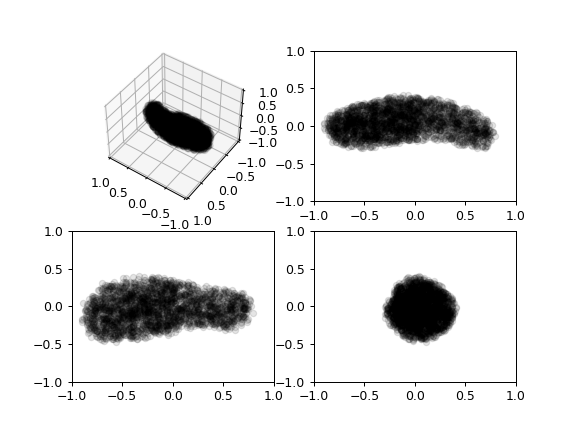

In [28]:
fig = plot_asteroid2(model, encoding, N=100000, bw=True, views_2d=True, alpha=0.1, s=100, crop_p=0.1)
#plt.title("Do I look like an asteroid now?")

#### Saving the model

In [29]:
# Uncomment to save to models/cluster_xxxx
torch.save(model.state_dict(), "models/" + key + "_" + cluster_name + "_" + encoding.name + hollow + ".mdl")

# TODO list:

* Code efficiency -> move to GPU and make training scalable to more sample points / mc points.
* MC integration -> importance sampling maybe?
* Network architecture -> study different encodings
* How to visualize and interpret the results quantitatively.
* Propagate trajectories around the asteroids (ground truth and trained).
* Incorporate visual cues.
* Training with gravity rather than potential?
* What happens for non uniform bodies?